# Training Multilayer Perceptron and a simple CNN

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Use GPU if available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Pytorch transformations for loading the data

In [4]:
INPUT_RESOLUTION = 32

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((INPUT_RESOLUTION, INPUT_RESOLUTION)),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.EuroSAT(
    './data',
    download=True,
    transform=input_transform
)
valset = torchvision.datasets.EuroSAT(
    './data',
    download=True,
    transform=input_transform
)
trainset, valset = torch.utils.data.random_split(dataset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=16,
    num_workers=2,
    shuffle=True
)
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)
CLASS_NAMES = dataset.classes
print(f'Found {len(trainloader)} train and {len(valloader)} val batches')
print(f'belonging to {len(CLASS_NAMES)} classes')

Found 1350 train and 338 val batches
belonging to 10 classes


### Show a few samples

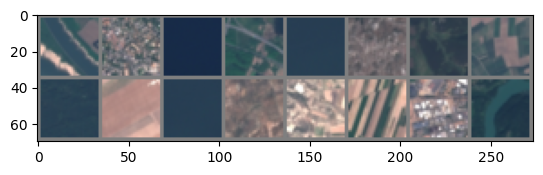

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

matplotlib_imshow(img_grid, one_channel=False)


### Define the model, loss function and optimizer

In [8]:
class OurMultilayerPerceptron(nn.Module):
    def __init__(self):
        super(OurMultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(3 * INPUT_RESOLUTION * INPUT_RESOLUTION, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, len(CLASS_NAMES))

    def forward(self, x):
        x = x.view(-1, 3 * INPUT_RESOLUTION * INPUT_RESOLUTION)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class OurCNN(nn.Module):
    def __init__(self):
        super(OurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 18, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 32, 3)
        self.fc1 = nn.Linear(32 * (INPUT_RESOLUTION//4 - 2) * (INPUT_RESOLUTION//4 - 2), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(CLASS_NAMES))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * (INPUT_RESOLUTION//4 - 2) * (INPUT_RESOLUTION//4 - 2))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

LEARNING_RATE = 0.03
LR_DECAY = 0.95
model = OurMultilayerPerceptron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY)
num_learnable_parameters = sum([
    p.numel() for p in model.parameters() if p.requires_grad
])
print(f'{num_learnable_parameters} learnable parameters')

394294 learnable parameters


### Use wandb to log training progress

In [9]:
import wandb
wandb.login()
wandb.init(
    project="iml_lab1",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_decay": LR_DECAY,
        "batch_size": trainloader.batch_size,
        "input_resolution": INPUT_RESOLUTION,
        "num_parameters": num_learnable_parameters,
        "architecture": "CNN",
        "dataset": "EuroSAT"
    }
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mrpralinka (mrpralinka-warsaw-university-of-technology). Use `wandb login --relogin` to force relogin


### Train. Save loss and accuracy for train and validation

In [10]:
model.to(device)
PRINT_STEP = len(trainloader) // 5 - 1

for epoch in range(0, 80):
    print(f'Epoch {epoch}')
    running_loss = 0.0
    correct = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predictions = torch.max(outputs.data, 1)
        correct += (predictions == labels).float().mean().item()

        running_loss += loss.item()
        if i % PRINT_STEP == PRINT_STEP-1:
            accuracy = correct / PRINT_STEP
            loss = running_loss / PRINT_STEP
            step = epoch * len(trainloader) + i
            wandb.log({
                    "train/accuracy": accuracy,
                    "train/loss": loss
                },
                step=step
            )
            running_loss = 0.0
            correct = 0

    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for j, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            val_correct += (predictions == labels).float().mean().item()

    accuracy = val_correct / len(valloader)
    loss = val_loss / len(valloader)
    wandb.log({
            "validation/accuracy": accuracy,
            "validation/loss": loss
        },
        step = (epoch + 1) * len(trainloader)
    )
    model.train()
    scheduler.step()

print('Finished Training')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Finished Training


### Plot a confusion matrix

In [11]:
model.eval()
y_true = []
y_predicted = []
with torch.no_grad():
    for j, data in enumerate(valloader, 0):
        inputs, labels = data
        y_true.extend(labels.numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        y_predicted.extend(predictions.cpu().numpy())
model.train()


confusion_matrix = wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_true,
    preds=y_predicted,
    class_names=CLASS_NAMES
)
wandb.log({
    "conf_mat" : confusion_matrix
})


### Save example images

In [15]:
table_data = []
for class_name in CLASS_NAMES:
    for i in range(1, 11):
        filename = f'{class_name}_{i}.jpg'
        filepath = f'data/eurosat/2750/{class_name}/{filename}'
        table_data.append([filename, class_name, wandb.Image(filepath)])
columns = ["filename", "class", "image"]
test_table = wandb.Table(data=table_data, columns=columns)
wandb.log({'example_samples': test_table})